In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from imutils import build_montages

In [3]:
df=pd.read_csv('/content/gdrive/My Drive/SponsoredProject/train-pairs-with_unrelated.csv')
img_sample = dict()

In [4]:
def looper(img_base_path, df):
  for index, row in df.iterrows():
    person1_path = img_base_path+row['p1']
    person2_path = img_base_path+row['p2']
    for filename in os.listdir(person1_path):
      if filename.endswith("jpg"): 
        if filename.startswith("Cropped"):
          print("Picked Cropped 1")
          if row['p1'] not in img_sample:
            n1 = cv2.imread(person1_path+'/'+filename)
            img_sample[row['p1']] = n1
          break
        else:
          if row['p1'] not in img_sample:
            n1 = cv2.imread(person1_path+'/'+filename)
            img_sample[row['p1']] = n1
          break
    for filename in os.listdir(person2_path):
      if filename.endswith("jpg"): 
        if filename.startswith("Cropped"):
          print("Picked Cropped 2")
          if row['p2'] not in img_sample:
            n1 = cv2.imread(person2_path+'/'+filename)
            img_sample[row['p2']] = n1
          break
        else:
          if row['p2'] not in img_sample:
            n1 = cv2.imread(person2_path+'/'+filename)
            img_sample[row['p2']] = n1
          break

In [5]:
img_base_path = 'gdrive/My Drive/SponsoredProject/train-faces/'

In [6]:
train_data = df.sample(frac=0.8)
test_data = df.drop(train_data.index)
looper(img_base_path, train_data)
looper(img_base_path, test_data)
train_img_pairs, train_img_labels = [], []
test_img_pairs, test_img_labels = [], []

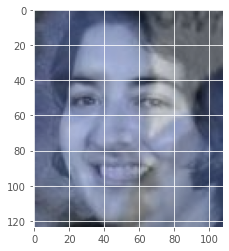

In [41]:
avg_face = []
for index, row in train_data.iterrows():
  avg_face.append(img_sample[row['p1']])
  avg_face.append(img_sample[row['p2']])
  break
avg_face=np.array(avg_face)
plt.imshow(avg_face.sum(axis=0)//avg_face.shape[0])

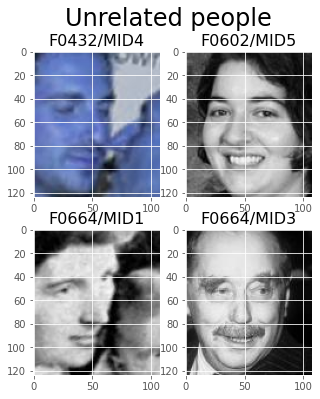

In [73]:
pp = os.path.sep.join([BASE_OUTPUT, "unrelated_people.png"])
def plot_relations(df, rows=1, titles=None):
  figsize=(5,3*rows)
  f = plt.figure(figsize=figsize)
  f.suptitle("Unrelated people", fontsize=24)
  x = 0
  for index, row in df.iterrows():
      if x>3:
        break
      sp = f.add_subplot(rows, 2, x+1)
      x+=1
      sp.set_title(row['p1'], fontsize=16)
      plt.imshow(img_sample[row['p1']])
      sp = f.add_subplot(rows, 2, x+1)
      x+=1
      sp.set_title(row['p2'], fontsize=16)
      plt.imshow(img_sample[row['p2']])
  plt.savefig(pp)
        
plot_relations(train_data, rows=2)

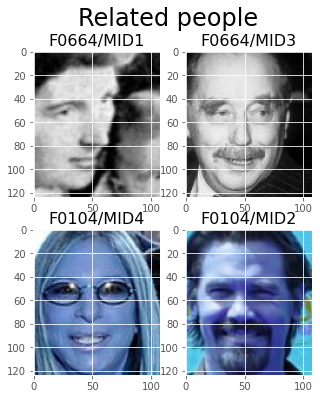

In [74]:
pp = os.path.sep.join([BASE_OUTPUT, "related_people.png"])
def plot_relations(df, rows=1, titles=None):
  figsize=(5,3*rows)
  f = plt.figure(figsize=figsize)
  f.suptitle("Related people", fontsize=24)
  x = 0
  for index, row in df.iterrows():
    if row['set']==0:
      if x>3:
        break
      sp = f.add_subplot(rows, 2, x+1)
      x+=1
      sp.set_title(row['p1'], fontsize=16)
      plt.imshow(img_sample[row['p1']])
      sp = f.add_subplot(rows, 2, x+1)
      x+=1
      sp.set_title(row['p2'], fontsize=16)
      plt.imshow(img_sample[row['p2']])
  plt.savefig(pp)
        
plot_relations(train_data, rows=2)

In [8]:
def read_img_pairs(df):
  img_pairs = []
  img_labels = []
  for index, row in df.iterrows():
    pair = []
    if(row['p1'] in img_sample.keys() and row['p2'] in img_sample.keys()):
      pair.append(np.expand_dims(np.array(cv2.resize(img_sample[row['p1']], (128, 128))/255.0), axis=-1))
      pair.append(np.expand_dims(np.array(cv2.resize(img_sample[row['p2']], (128, 128))/255.0), axis=-1))
      img_pairs.append(pair)
      img_labels.append(1 if row['set']==0 else 0)
  return (img_pairs, img_labels)

train_img_pairs, train_img_labels = read_img_pairs(train_data)
test_img_pairs, test_img_labels = read_img_pairs(test_data)

unique, counts = np.unique(train_img_labels, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(test_img_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5541, 1: 5609}
{0: 1413, 1: 1374}


In [9]:
import gc
print(len(train_img_labels))
gc.collect()
images = []

11150


In [10]:
pairTrain = np.array(train_img_pairs)
labelTrain = np.array(train_img_labels)
pairTest = np.array(test_img_pairs)
labelTest = np.array(test_img_labels)

In [11]:
#Now we write our model
gc.collect()
IMG_SHAPE = (128, 128, 3)
BATCH_SIZE = 64
EPOCHS = 100
BASE_OUTPUT = '/content/gdrive/My Drive/SponsoredProject/'
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D

In [13]:
def build_siamese_model(inputShape, embeddingDim=48):
  inputs = Input(inputShape)
  # define the first set of CONV => RELU => POOL => DROPOUT layers
  x = Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
  x = MaxPooling2D(pool_size=(2, 2), padding="same")(x)
  x = Dropout(0.3)(x)
  # second set of CONV => RELU => POOL => DROPOUT layers
  x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
  x = MaxPooling2D(pool_size=(2, 2), padding="same")(x)
  x = Dropout(0.3)(x)
  # third set of CONV => RELU => POOL => DROPOUT layers
  x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
  x = AveragePooling2D(pool_size=(8, 8), padding="same")(x)
  x = Dropout(0.3)(x)

  pooledOutput = GlobalAveragePooling2D()(x)
  outputs = Dense(embeddingDim)(pooledOutput)
  model = Model(inputs, outputs)
  return model

import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

def plot_training(H, plotPath):
  # construct a plot that plots and saves the training history
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(H.history["loss"], label="train_loss")
  plt.plot(H.history["val_loss"], label="val_loss")
  plt.plot(H.history["accuracy"], label="train_acc")
  plt.plot(H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")
  plt.savefig(plotPath)

In [14]:
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

[INFO] building siamese network...


In [75]:
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 48)           58288       ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

In [16]:
# from keras.optimizers import SGD
# opt = SGD(lr=0.01)
# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# train the model
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],use_multiprocessing=True,
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=100)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
175/175 [==============================] - 93s 523ms/step - loss: 0.6868 - accuracy: 0.5246 - val_loss: 0.6842 - val_accuracy: 0.5551
Epoch 2/100
175/175 [==============================] - 93s 530ms/step - loss: 0.6800 - accuracy: 0.5674 - val_loss: 0.6769 - val_accuracy: 0.5745
Epoch 3/100
175/175 [==============================] - 93s 530ms/step - loss: 0.6761 - accuracy: 0.5795 - val_loss: 0.6695 - val_accuracy: 0.5971
Epoch 4/100
175/175 [==============================] - 93s 529ms/step - loss: 0.6732 - accuracy: 0.5853 - val_loss: 0.6833 - val_accuracy: 0.5669
Epoch 5/100
175/175 [==============================] - 85s 488ms/step - loss: 0.6703 - accuracy: 0.5894 - val_loss: 0.6706 - val_accuracy: 0.5727
Epoch 6/100
175/175 [==============================] - 71s 404ms/step - loss: 0.6692 - accuracy: 0.5925 - val_loss: 0.6686 - val_accuracy: 0.5981
Epoch 7/100
175/175 [==============================] - 71s 407ms/step - l

Saving our model...
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/SponsoredProject//siamese_model/assets
Plotting training history...


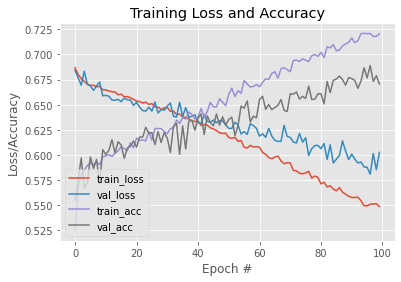

In [18]:
# serialize the model to disk
print("Saving our model...")
model.save(MODEL_PATH)
# plot the training history
print("Plotting training history...")
plot_training(history, PLOT_PATH)

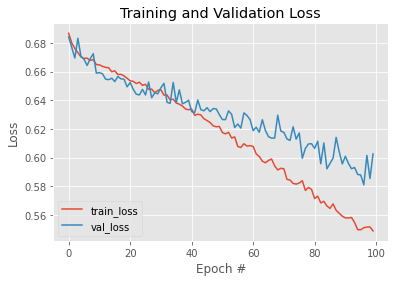

In [21]:
pp = os.path.sep.join([BASE_OUTPUT, "loss_plot.png"])
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(pp)

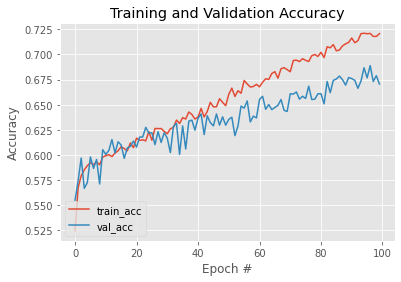

In [22]:
pp = os.path.sep.join([BASE_OUTPUT, "acc_plot.png"])
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig(pp)